# Classification Data Preparation
**Traprock KBA, QLD - Change Detection Jul 2015 to Jul 2023**


Author: Michael Dear, May 2024

This notebook adds classification variables to the dataset.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class_num']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Jul 2015', 'Jul 2023']

## Step 2: Classification

### Ground-truth Points (GTP)
The process is:
1. Create polygons for each class using QGIS, Google Earth, and composite plots for each period.
2. Intersect the polygons with the data array to create a candidate set of points for each period.
3. Reduce the candidate set in each class to the size of the smallest class.
4. Train the classifier.
5. Predict.

See https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe for converting a data array to points.

In [7]:
# Read in the labelled polygons
gtp_polys = [gpd.read_file(vector_dir+'gtp_polygons_'+str(i)+'.geojson').to_crs(crs) for i in [0,1]]

In [8]:
for i in [0,1]:
    print(gtp_polys[i].head())

   class_num    class_name                                           geometry
0          1         Grass  MULTIPOLYGON (((1876057.375 -3231564.132, 1876...
1          2  Sparse Woody  MULTIPOLYGON (((1893559.363 -3221048.426, 1894...
2          3   Dense Woody  MULTIPOLYGON (((1895709.035 -3207608.748, 1896...
   class_num    class_name                                           geometry
0          1         Grass  MULTIPOLYGON (((1876057.375 -3231564.132, 1876...
1          3   Dense Woody  MULTIPOLYGON (((1895709.035 -3207608.748, 1896...
2          2  Sparse Woody  MULTIPOLYGON (((1896445.287 -3223126.289, 1896...


In [9]:
for i in [0,1]:
    gtp_polys[i]['geometry'] = gtp_polys[i].buffer(-spatial_res)
    print(gtp_polys[i].head())

   class_num    class_name                                           geometry
0          1         Grass  MULTIPOLYGON (((1895989.219 -3224376.588, 1896...
1          2  Sparse Woody  MULTIPOLYGON (((1896041.478 -3222720.746, 1896...
2          3   Dense Woody  MULTIPOLYGON (((1900356.543 -3219429.489, 1901...
   class_num    class_name                                           geometry
0          1         Grass  MULTIPOLYGON (((1895989.219 -3224376.588, 1896...
1          3   Dense Woody  MULTIPOLYGON (((1900356.543 -3219429.489, 1901...
2          2  Sparse Woody  MULTIPOLYGON (((1896843.051 -3223718.881, 1896...


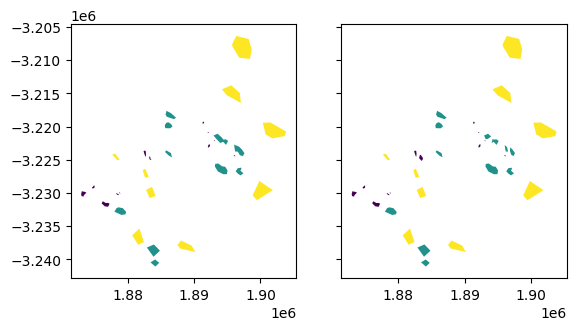

In [10]:
# Plot to check the data
fig, axes = plt.subplots(1,2, sharey=True)
for i in [0,1]:
    unq_nums = np.unique(gtp_polys[i]['class_num'])
    gtp_polys[i].plot(ax=axes[i], column='class_num')

In [11]:
X_vars = list(ds.data_vars.keys())[:8]
X_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR']

In [24]:
gtp_base = [[],[]]

for i in [0,1]:
    # Convert the data array to a data frame
    df = ds.isel(period=i).to_dataframe().reset_index()
    
    # Convert to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

    # Make a bare/water class using NDVI threshold
    bare = gdf[gdf['NDVI']<= 0.195]
    bare['class_num'] = 0
    bare['class_name'] = 'Bare'
    
    # Add internal buffer
    # gdf['geometry'] = gdf.buffer(-(spatial_res/2))
    
    # Intersect the points with the polygons
    gdf = gpd.sjoin(gdf, gtp_polys[i], how='inner') # Limit to polygon
    gtp_base[i] = pd.concat([gdf[X_vars+['class_num','class_name','geometry']], bare[X_vars+['class_num','class_name','geometry']]], axis=0)


In [15]:
# Convert the data array to a data frame
df = ds.isel(period=0).to_dataframe().reset_index()

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

In [20]:
# Make a bare/water class using NDVI threshold
bare = gdf[gdf['NDVI']<= 0.195]
bare['class_num'] = 0
bare['class_name'] = 'Bare'
bare.head()

,y,x,spatial_ref,period,nbart_red,nbart_blue,nbart_green,nbart_nir,nbart_swir_1,nbart_swir_2,NDVI,NBR,NDVI_Class,Kmeans_Class,RF_Class,geometry,class_num,class_name
2479,-3200265.0,1873365.0,3577,Jul 2015,1672.0,730.0,1198.0,2412.0,3808.0,2974.0,0.181195,-0.104345,0,2.0,0,POINT (1873365.000 -3200265.000),0,Bare
3128,-3200265.0,1892835.0,3577,Jul 2015,2447.0,1314.0,2037.0,3506.0,4686.0,4052.0,0.177894,-0.072241,0,0.0,0,POINT (1892835.000 -3200265.000),0,Bare
4891,-3200325.0,1873485.0,3577,Jul 2015,1815.0,779.0,1298.0,2482.0,3603.0,2796.0,0.155225,-0.059492,0,2.0,0,POINT (1873485.000 -3200325.000),0,Bare
6095,-3200355.0,1873485.0,3577,Jul 2015,1867.0,762.0,1406.0,2433.0,3493.0,2577.0,0.131628,-0.028742,0,2.0,0,POINT (1873485.000 -3200355.000),0,Bare
10441,-3200445.0,1895505.0,3577,Jul 2015,1418.0,683.0,1084.0,2070.0,2774.0,2185.0,0.186927,-0.027027,0,2.0,0,POINT (1895505.000 -3200445.000),0,Bare


In [25]:
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i].head())
    print('--------------')

Period: 0
        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
248862      346.0       209.0        294.0     1399.0        1286.0   
248863      350.0       205.0        290.0     1446.0        1262.0   
248864      372.0       221.0        300.0     1411.0        1347.0   
250065      388.0       214.0        331.0     1574.0        1344.0   
250066      353.0       205.0        300.0     1440.0        1270.0   

        nbart_swir_2      NDVI       NBR  class_num   class_name  \
248862         716.0  0.603438  0.322931          3  Dense Woody   
248863         686.0  0.610245  0.356473          3  Dense Woody   
248864         762.0  0.582726  0.298665          3  Dense Woody   
250065         770.0  0.604485  0.343003          3  Dense Woody   
250066         712.0  0.606246  0.338290          3  Dense Woody   

                                geometry  
248862  POINT (1896375.000 -3206385.000)  
248863  POINT (1896405.000 -3206385.000)  
248864  POINT (1896435.00

In [26]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
3    30700
2    12604
1     1753
0     1703
Name: count, dtype: int64
--------------
Period: 1
class_num
3    30700
0    12479
2    11595
1     2011
Name: count, dtype: int64
--------------


In [27]:
# Reduce each class to the size of the smallest class
sample_size = np.min([gtp_base[i]['class_num'].value_counts().min() for i in [0,1]])

gtp_equal = [pd.concat([gtp_base[i][gtp_base[i]['class_num']==cl].sample(sample_size, random_state=random_state) 
                for cl in gtp_base[i]['class_num'].unique()], axis=0) 
                for i in [0,1]]

In [28]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_equal[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
3    1703
2    1703
1    1703
0    1703
Name: count, dtype: int64
--------------
Period: 1
class_num
3    1703
2    1703
1    1703
0    1703
Name: count, dtype: int64
--------------


### NDVI Classification

The following are typical NDVI thresholds based on the literature. These will need to be adjusted for each period from the results of the GTP analysis. 
|Class Number|Class Name|Class Description|Threshold|
|:-:|:-|:-|:-:|
|1|Water|Deep water bodies e.g. lakes, rivers|$$\text{NDVI} \lt 0$$|
|2|Bare|Bare ground|$$0 \le \text{NDVI} \lt 0.15$$|
|3|Sparse|Sparse vegetation e.g. scattered shrubs, patchy grass|$$0.15 \le \text{NDVI} \lt 0.5$$|
|4|Medium-density|Medium-density vegetation e.g. woodland; post-fire regrowth|$$0.5 \le \text{NDVI} \lt 0.8$$|
|5|High-density|Dense vegetation e.g. forest|$$\text{NDVI} \ge 0.8$$|
|6|Masked|No data|nan|

The thresholds were derived from the following sources:

* [Map Information - Normalised Difference Vegetation Index: Australian Bureau of Meterology](http://www.bom.gov.au/climate/austmaps/about-ndvi-maps.shtml)
* [NDVI, the Foundation for Remote Sensing Phenology : USGS](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology)

#### Imports

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#### Create the training and test sets

In [30]:
X = [gdf['NDVI'] for gdf in gtp_equal]
y = [gdf[y_var] for gdf in gtp_equal]

In [31]:
gtp_tt = [train_test_split(X[i], y[i], test_size=0.2, random_state=random_state) for i in [0,1]]

#### GTP Analysis

In [32]:
# Summarise by Class
for i in [0,1]:
    print('Period:', i)
    df = pd.DataFrame(data={'NDVI':gtp_tt[i][0],
                           'class_num':gtp_tt[i][2]['class_num']})
    print(df.groupby('class_num').agg({'NDVI':['min','max','mean','median']}))
    print('----------')

Period: 0
               NDVI                              
                min       max      mean    median
class_num                                        
0         -0.743274  0.194984  0.076677  0.148088
1          0.290046  0.567069  0.413296  0.414386
2          0.270374  0.696715  0.450672  0.442633
3          0.508128  0.784367  0.668661  0.671217
----------
Period: 1
               NDVI                              
                min       max      mean    median
class_num                                        
0         -0.954155  0.194783  0.107813  0.133759
1          0.201952  0.536804  0.304835  0.294476
2          0.220447  0.736551  0.407361  0.396965
3          0.480947  0.776790  0.656698  0.663075
----------


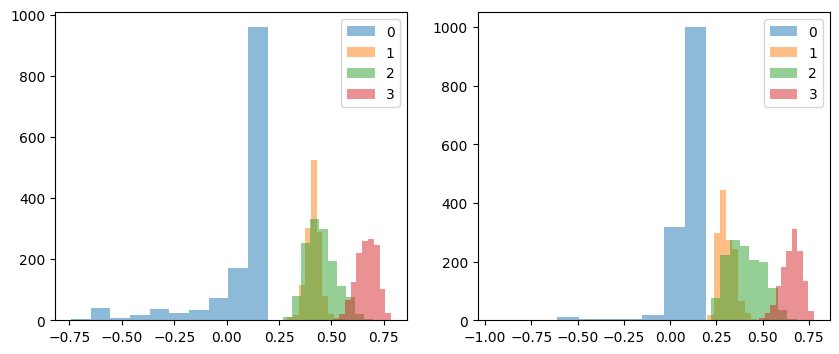

In [33]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for i in [0,1]:
    cl_nums = np.sort(gtp_tt[i][2]['class_num'].unique())
    for cl in cl_nums:
        axes[i].hist(gtp_tt[i][0][gtp_tt[i][2]['class_num']==cl], alpha=0.5)
    
    axes[i].legend(cl_nums)

#### Create the NDVI classification dataset
<a id='create_classification'></a>

In [39]:
# Function to make threshold classification variable
# See https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_calculate_classify_ndvi.html for np.digitize
# See https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html for assigning numpy array to a dataset

# Needed to set the order of the dims explicitly in this case - not the same as ds.dims
def make_class_var(ds, class_bins, var, newvar):
    class_arr = np.empty(ds[var].values.shape)
    
    class_arr = [np.digitize(ds[var].sel(period=period), class_bins[i]).astype(np.int16) 
     for i, period in enumerate(ds.period.values)]

    # Subtract 1 from class values to align with other classification methods
    class_arr = np.array(class_arr)-1
    
    # ds = ds.assign({newvar: (('period','y','x'), class_arr)})
    # return ds
    
    return class_arr

In [34]:
# Use mean or median for first n-2 classes
# Use the minimum of the nth class as the upper bound of the (n-1)th class
# No upper bound required for the nth class (it is np.inf)
NDVI_class_bins = [
    [-np.inf, 0.195, 0.475, 0.6, np.inf],
    [-np.inf, 0.195, 0.45, 0.55, np.inf]
]

#### Accuracy assessment

In [35]:
y_preds = [np.digitize(gtp_tt[i][1], NDVI_class_bins[i]).astype(np.int16)-1 
     for i in [0,1]]

# for i in [0,1]:
#     print('Period:', i)
#     print('Actual')
#     print(gtp_tt[i][3][:5])
#     print('Predicted')
#     print(y_preds[i][:5])
#     print('----------')

In [36]:
# Assess accuracy
accuracy = [accuracy_score(gtp_tt[i][3], y_preds[i]) for i in [0,1]]
for i in [0,1]:
    print(accuracy[i])

0.8011738811445341
0.80997798972854


In [37]:
# Confusion matrix
cm = [confusion_matrix(gtp_tt[i][3], y_preds[i]) for i in [0,1]]
for i in [0,1]:
    print('Confusion matrix')
    print(cm[i])
    print('--------')

Confusion matrix
[[337   0   0   0]
 [  0 316  12   0]
 [  0 217  97  10]
 [  0   0  32 342]]
--------
Confusion matrix
[[337   0   0   0]
 [  0 324   2   2]
 [  0 218  79  27]
 [  0   0  10 364]]
--------


#### Make the final classification

In [40]:
class_arr = make_class_var(ds, class_bins = NDVI_class_bins, var='NDVI', newvar='NDVI_Class')
ds = ds.assign({'NDVI_Class': (('period','y','x'), class_arr)})

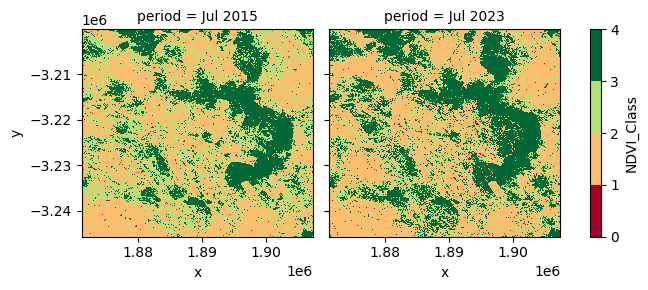

In [41]:
# Plot of NDVI_Class
ds.NDVI_Class.plot(col='period', 
                   cmap='RdYlGn', 
                   levels = np.arange(len(np.unique(ds.NDVI_Class))+1)
                  )

### Kmeans Classification
Method
* Fit for a given period using all the GTP data.
* Predict on the whole dataset for the period.
  
Based on https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

#### Imports

In [42]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#### Select the variables to use in the classification

In [43]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDVI_Class',
 'Kmeans_Class',
 'RF_Class']

In [44]:
km_vars = [list(ds.data_vars.keys())[i] for i in [0,2,3,4]]

#### Create the training and test sets

In [45]:
X = [gdf[km_vars] for gdf in gtp_equal]

In [46]:
X[0].head()

,nbart_red,nbart_green,nbart_nir,nbart_swir_1
1053879,378.0,404.0,1806.0,1258.0
335561,340.0,295.0,1451.0,1263.0
595564,354.0,317.0,1836.0,1235.0
817319,386.0,351.0,1929.0,1412.0
847494,367.0,335.0,2123.0,1338.0


#### Standardise the training data

In [47]:
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

for i in [0,1]:
    x = X[i][km_vars].values # returns a numpy array
    x_norm = scaler.fit_transform(x)
    X[i][km_vars] = x_norm
    print(X[i].head())

         nbart_red  nbart_green  nbart_nir  nbart_swir_1
1053879  -1.012237    -0.868666  -0.355587     -1.073110
335561   -1.089404    -1.157026  -1.074473     -1.067600
595564   -1.060974    -1.098825  -0.294837     -1.098457
817319   -0.995992    -1.008877  -0.106509     -0.903398
847494   -1.034575    -1.051206   0.286346     -0.984948
         nbart_red  nbart_green  nbart_nir  nbart_swir_1
1053879  -1.046956    -0.862960  -0.693822     -1.284392
335561   -1.141941    -1.135231  -0.638277     -1.446766
595564   -1.112582    -1.085133  -0.899097     -1.288722
817319   -1.041775    -0.947909   0.216632     -1.204288
847494   -1.038321    -0.984938  -0.326743     -1.115523


#### Determine best K
See https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

In [48]:
ks = np.arange(1,10)

# Set random_state for reproducibility
km = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [49]:
scores = [[k.fit(X[i]).score(X[i]) for k in km] for i in [0,1]]

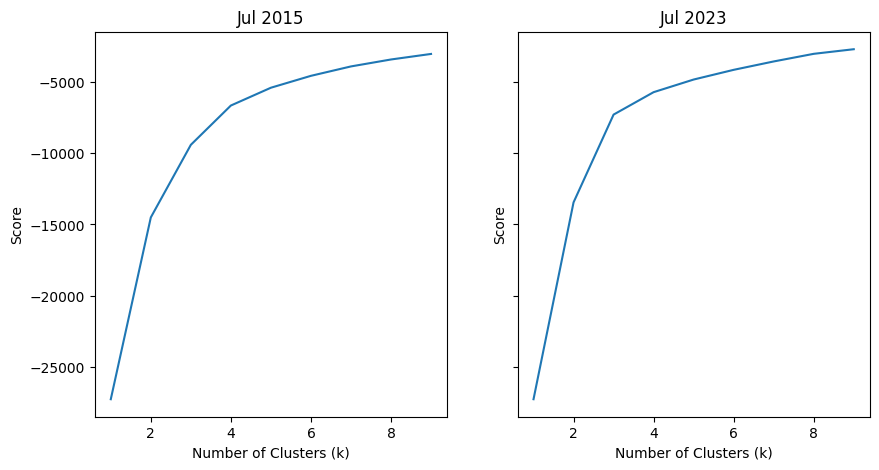

In [50]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for i, period in enumerate(periods):
    axes[i].plot(ks, scores[i])
    axes[i].set_xlabel('Number of Clusters (k)')
    axes[i].set_ylabel('Score')
    axes[i].set_title(period)

#### Standardise the dataframe

In [51]:
df = ds[km_vars].to_dataframe().reset_index(['x','y'], drop=True).drop('spatial_ref', axis=1)

# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

x = df[km_vars].values # returns a numpy array
x_norm = scaler.fit_transform(x)
df[km_vars] = x_norm
df.head()

,nbart_red,nbart_green,nbart_nir,nbart_swir_1
period,,,,
Jul 2015,-0.602728,-0.533046,0.701454,-0.603779
Jul 2015,-0.917775,-0.829599,-0.307478,-1.028821
Jul 2015,-0.936307,-0.795001,-0.214504,-1.048267
Jul 2015,-0.873298,-0.755461,-0.080210,-0.927422
Jul 2015,-0.973372,-0.819714,0.260692,-1.178836


In [52]:
# Array to hold the final classifications
km_arrs = [[] for i in [0,1]]

In [53]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

#### Predict on all data for each period

In [54]:
ks = [4,4]
# Set random_state for reproducibility
km = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [55]:
km_fit = [km[i].fit(X[i]) for i in [0,1]]

In [56]:
km_arrs = [km_fit[i].predict(df.loc[periods[i]]).reshape(w,l) for i in [0,1]]

#### Plot to check the data

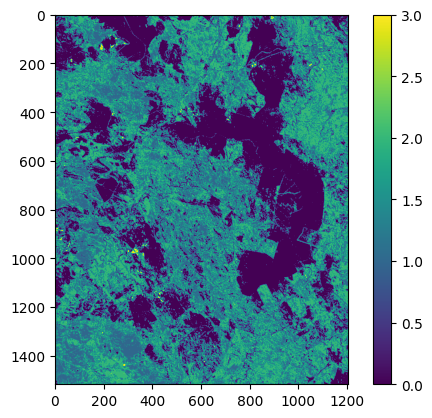

In [57]:
plt.imshow(km_arrs[0])
plt.colorbar()

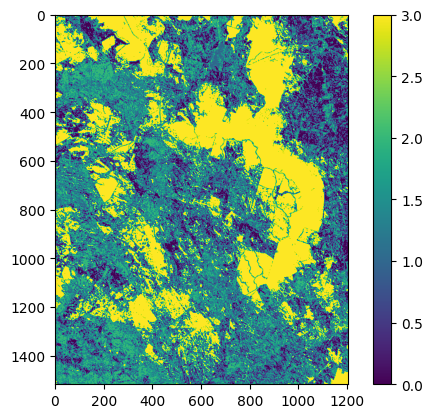

In [59]:
plt.imshow(km_arrs[1])
plt.colorbar()

#### Add the classification data to the dataset

In [60]:
# Convert to int16
km_arrs = np.array(km_arrs, dtype=np.int16)

In [61]:
ds = ds.assign({'Kmeans_Class': (('period','y','x'), km_arrs)})

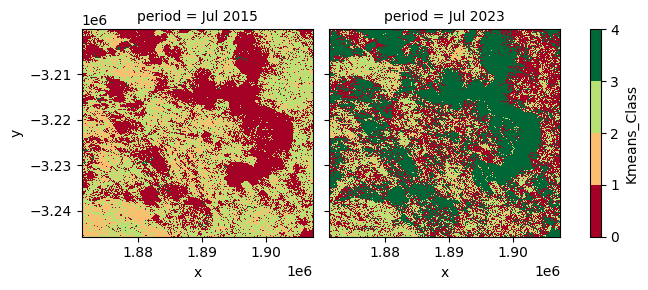

In [62]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

#### Re-code Classes (Optional)


In [66]:
old_vals = np.array(km_arrs)

In [67]:
new_vals = np.empty(old_vals.shape)
new_vals.shape

(2, 1518, 1204)

In [68]:
# Use the same re-code values for both periods if using Option 1.
recode = (
    [(0,3),(1,1),(2,2),(3,0)],
    [(0,2),(1,0),(2,1),(3,3)]
)

In [69]:
for i in [0,1]:
    for j in np.arange(len(np.unique(old_vals[i]))):
        new_vals[i][old_vals[i]==recode[i][j][0]] = recode[i][j][1]

In [70]:
ds.Kmeans_Class.values = new_vals

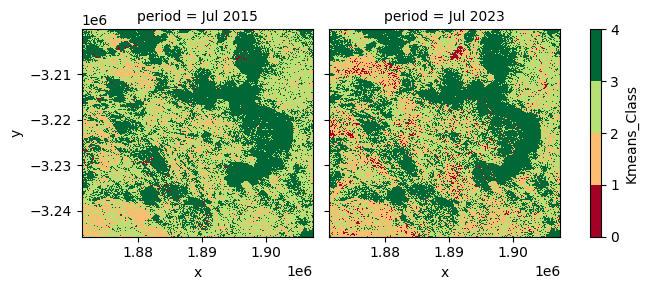

In [71]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

## Step 3: Random Forest
Based on
* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

#### Imports

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#### Create the training and test sets

In [73]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDVI_Class',
 'Kmeans_Class',
 'RF_Class']

In [74]:
rf_vars = [list(ds.data_vars.keys())[i] for i in np.arange(8)]
rf_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR']

In [75]:
X = [gdf[rf_vars] for gdf in gtp]
y = [gdf[y_var] for gdf in gtp]

NameError: name 'gtp' is not defined

In [469]:
gtp_tt = [train_test_split(X[i], y[i], test_size=0.2, random_state=random_state) for i in [0,1]]

In [470]:
for i in [0,1]:
    print(gtp_tt[i][0][:5])
    print(gtp_tt[i][2][:5])

         nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
1224228      332.0       193.0        328.0     2307.0        1176.0   
612488       309.0       183.0        298.0     1794.0        1179.0   
843839       397.0       212.0        365.0     2252.0        1457.0   
722886       636.0       397.0        508.0     1849.0        1990.0   
772265       780.0       423.0        649.0     2091.0        2145.0   

         nbart_swir_2      NDVI  
1224228         547.0  0.748390  
612488          605.0  0.706134  
843839          740.0  0.700264  
722886         1222.0  0.488129  
772265         1458.0  0.456635  
         class_num
1224228          3
612488           3
843839           3
722886           2
772265           2
         nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
1154760      961.0       512.0        769.0     1839.0        2992.0   
1252330     1008.0       540.0        785.0     1729.0        3183.0   
1534458      439.0       270.0   

#### Basic RF

In [479]:
%%time

# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Split the data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
    # Create and fit the RF classifier
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Append model to list
    rfs.append(rf)
    
    # Predict
    y_pred = rf.predict(gtp_tt[i][1])
    
    # Assess accuracy
    accuracy = accuracy_score(gtp_tt[i][3], y_pred)

    print(periods[i])
    print('============')
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(rf.feature_importances_, index=gtp_tt[i][0].columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(gtp_tt[i][3], y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Jul 2015
Accuracy: 0.9389954518489223

Feature Importance
nbart_swir_2    0.251781
nbart_red       0.243824
nbart_swir_1    0.179243
nbart_green     0.123576
NDVI            0.105084
nbart_blue      0.058613
nbart_nir       0.037879
dtype: float64

Confusion matrix
[[  90    4   77    3]
 [   0  315  234    1]
 [  12   89 2573  126]
 [   0    0   71 6519]]

Jul 2023
Accuracy: 0.9473212507468631

Feature Importance
nbart_red       0.259641
nbart_swir_1    0.214701
nbart_swir_2    0.188685
nbart_green     0.137784
NDVI            0.091528
nbart_blue      0.072924
nbart_nir       0.034737
dtype: float64

Confusion matrix
[[ 114    0    1    0]
 [   0  377  191    0]
 [   3  105 2525  115]
 [   0    0  114 6497]]



#### RF With Hyperparameter Tuning
*Warning*: This will take a long time to complete.

In [488]:
%%time

# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Create the parameter grid
    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5)

    # Split the data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
   
    # Fit the random_search to the data
    rand_search.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Store the best model
    best_rf = rand_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(gtp_tt[i][1])
    accuracy = accuracy_score(gtp_tt[i][3], y_pred)

    # Append best model to list
    rfs.append(best_rf)

    print(periods[i])
    print('============')
    # print('y_test:', y_test['class'].values)
    # print('y_pred:', y_pred)
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(best_rf.feature_importances_, index=gtp_tt[i][0].columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(gtp_tt[i][3], y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Jul 2015
Accuracy: 0.938006723353767

Feature Importance
nbart_swir_2    0.245012
nbart_red       0.238164
nbart_swir_1    0.156639
nbart_green     0.133209
NDVI            0.118846
nbart_blue      0.075049
nbart_nir       0.033079
dtype: float64

Confusion matrix
[[  88    4   79    3]
 [   0  304  244    2]
 [  10   84 2573  133]
 [   0    0   68 6522]]



KeyboardInterrupt: 

#### Predictions for each period

In [480]:
rf_arrs = [[] for i in [0,1]]

In [483]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

In [484]:
rf_arrs = [rfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[rf_vars].values).reshape(w,l) for i, period in enumerate(periods)]

#### Add the classification data to the dataset

In [485]:
ds = ds.assign({'RF_Class': (('period','y','x'), rf_arrs)})

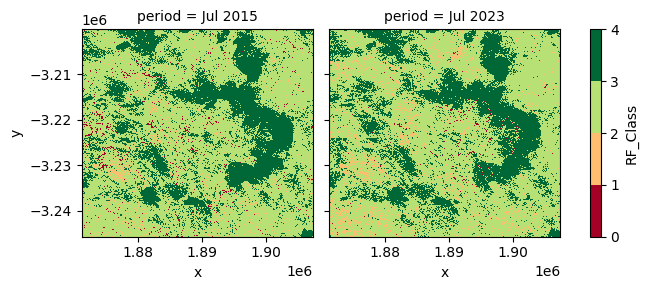

In [486]:
ds.RF_Class.plot(col='period', 
                 levels=np.arange(len(np.unique(ds.RF_Class))+1),
                 cmap='RdYlGn')

## Step 4: Export data 

### netCDF

In [489]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [491]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )

In [492]:
ds

<xarray.Dataset>
Dimensions:       (y: 1518, x: 1204, period: 2)
Coordinates:
  * y             (y) float64 -3.2e+06 -3.2e+06 ... -3.246e+06 -3.246e+06
  * x             (x) float64 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Jul 2015' 'Jul 2023'
Data variables:
    nbart_red     (period, y, x) float32 532.0 447.0 442.0 ... 448.0 381.0 351.0
    nbart_blue    (period, y, x) float32 328.0 286.0 302.0 ... 224.0 180.0 175.0
    nbart_green   (period, y, x) float32 470.0 410.0 417.0 ... 367.0 336.0 297.0
    nbart_nir     (period, y, x) float32 2.131e+03 1.838e+03 ... 1.326e+03
    nbart_swir_1  (period, y, x) float32 1.773e+03 1.467e+03 ... 1.475e+03
    nbart_swir_2  (period, y, x) float32 998.0 821.0 820.0 ... 925.0 893.0
    NDVI          (period, y, x) float32 0.6005 0.6088 0.6168 ... 0.5804 0.5814
    NBR           (period, y, x) float32 0.3621 0.3825 0.3892 ... 0.2161 0.1951
    NDVI_Class    (period, y, x) int16 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 2 2 3 3
    Kmeans_Class  (period, y, x) float64 1.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    RF_Class      (period, y, x) int64 2 3 3 3 3 3 3 3 3 2 ... 3 3 3 3 3 2 3 3 3